## Load Data Directory

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("moanlobago/crop-pestdatasets")

# print("Path to dataset files:", path)

## Dependencies

In [2]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

Essential building blocks for neural networks, optimization, and data handling

In [3]:
# Vision-specific imports
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

 Pre-trained models, image transformations, and dataset utilities designed for computer vision tasks

In [4]:
# Image processing
from PIL import Image
import cv2

Tools for loading, manipulating, and preprocessing your maize leaf images

In [5]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

For exploring your dataset, visualizing results, and handling any metadata you might create

In [6]:
# System and file handling
import os
import glob
from pathlib import Path
import random
import shutil

# Model evaluation and metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Progress tracking and utilities
from tqdm import tqdm
import time
import copy
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [8]:
# Set your dataset path
dataset_path = Path('/kaggle/input/crop-pestdatasets/Combined_pestDataset')

In [9]:
train = pd.read_csv(dataset_path / 'Train.csv')
test = pd.read_csv(dataset_path / 'Test.csv')

In [10]:
train.head()

Image_id  Label
0  id_02amazy34fgh2.jpg      1
1  id_02mh3w48pmyc9.jpg      0
2  id_02rpb463h9d3w.jpg      0
3  id_02wc3jeeao8ol.jpg      1
4  id_03t2hapb8wz8p.jpg      1

In [11]:
train['Label'].value_counts()

Label
0    810
1    809
Name: count, dtype: int64

## Data Preprocessing

#### Data Transformation

In [12]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

## Data Preparation

In [13]:
source_dir = dataset_path / 'Images'
output_dir = '/kaggle/working/dataset_path'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create train class folders
for label in train['Label'].unique():
    os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)

# Create test folder (no class folders)
os.makedirs(test_dir, exist_ok=True)

# Move train images
for _, row in train.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(train_dir, str(row['Label']), row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

# Move test images
for _, row in test.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(test_dir, row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

#### Load the training dataset

In [14]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)

#### Handling test set

In [15]:
# Use this dataset class for test data
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(image_path)  # Return image + filename

# Create test dataset
test_image_paths = list(Path(test_dir).glob("*.jpg"))
test_dataset = TestDataset(test_image_paths, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Create DataLoaders

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

#### Confirm class mapping

In [17]:
print(train_dataset.class_to_idx)

{'0': 0, '1': 1}


In [18]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.4


### Split Training Data into Train/Validation

In [19]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

## Model Definition

In [20]:
model = models.resnet50(pretrained=True) 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Set output to match number of classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


## Loss Function & Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop with Validation

In [22]:
num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Statistics
    train_loss = running_loss / len(train_subset)
    val_loss = val_loss / len(val_subset)
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 41/41 [00:56<00:00,  1.37s/it]


Epoch 1/10
Train Loss: 0.1723 | Val Loss: 0.2177 | Val Acc: 0.9290


100%|██████████| 41/41 [00:55<00:00,  1.34s/it]


Epoch 2/10
Train Loss: 0.1096 | Val Loss: 0.0290 | Val Acc: 0.9938


100%|██████████| 41/41 [00:54<00:00,  1.33s/it]


Epoch 3/10
Train Loss: 0.0741 | Val Loss: 0.0455 | Val Acc: 0.9877


100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Epoch 4/10
Train Loss: 0.0456 | Val Loss: 0.3272 | Val Acc: 0.8920


100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Epoch 5/10
Train Loss: 0.0445 | Val Loss: 0.0475 | Val Acc: 0.9877


100%|██████████| 41/41 [00:53<00:00,  1.31s/it]


Epoch 6/10
Train Loss: 0.0426 | Val Loss: 0.0540 | Val Acc: 0.9691


100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Epoch 7/10
Train Loss: 0.0387 | Val Loss: 0.0201 | Val Acc: 0.9969


100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Epoch 8/10
Train Loss: 0.0255 | Val Loss: 0.0444 | Val Acc: 0.9815


100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Epoch 9/10
Train Loss: 0.0218 | Val Loss: 0.0266 | Val Acc: 0.9938


100%|██████████| 41/41 [00:54<00:00,  1.33s/it]


Epoch 10/10
Train Loss: 0.0546 | Val Loss: 0.0353 | Val Acc: 0.9877


In [23]:
# Inference (without labels)
model.eval()
all_filenames = []
all_preds = []

with torch.no_grad():
    for inputs, filenames in test_loader:  # Now getting filenames instead of labels
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_filenames.extend(filenames)

# Create submission DataFrame
results_df = pd.DataFrame({
    'Image_id': all_filenames,
    'Predicted_Label': all_preds
})

In [24]:
results_df.head()

Image_id  Predicted_Label
0  id_3aqdme2q8hp6n.jpg                1
1  id_qs1akpsidz7t2.jpg                1
2  id_p1a0ikrgk1fco.jpg                0
3  id_igy2j3mdxebth.jpg                1
4  id_deyup3jir6mea.jpg                0

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       172
           1       0.98      0.99      0.99       152

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.99      0.99       324



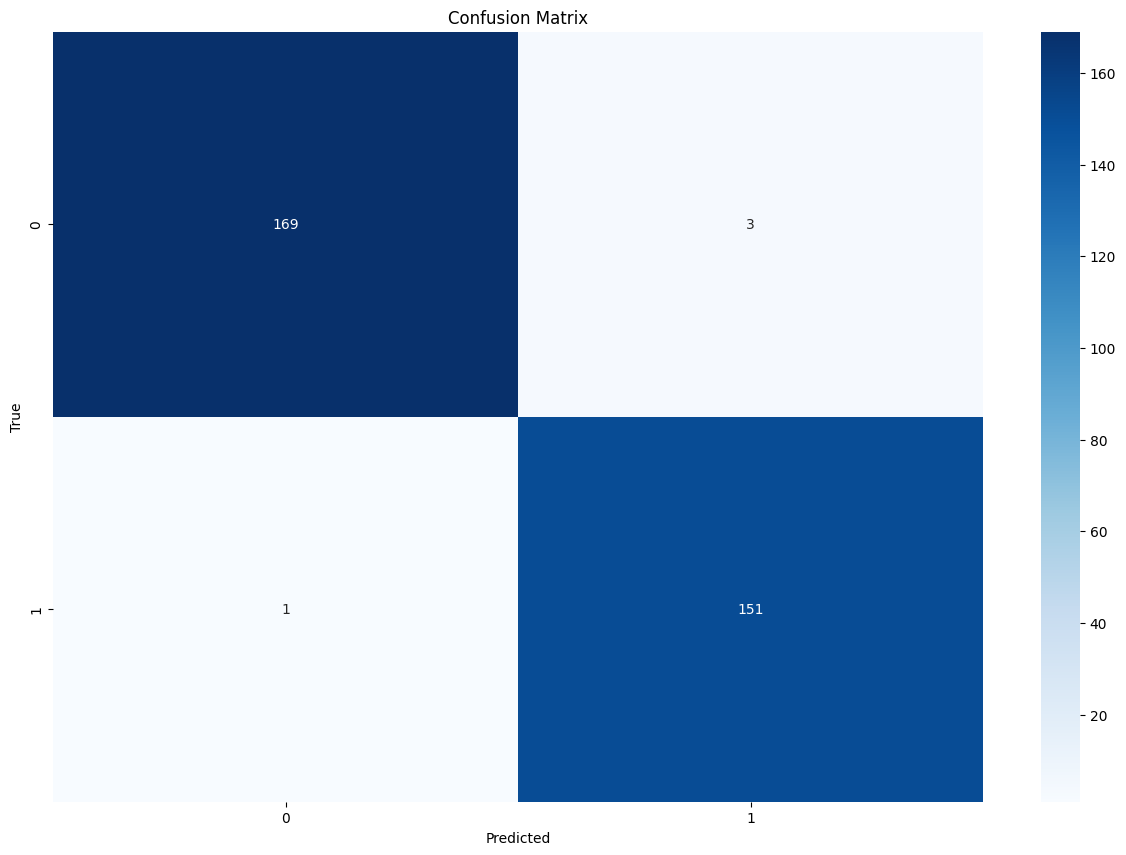

In [25]:
# Get predictions for validation set
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show();

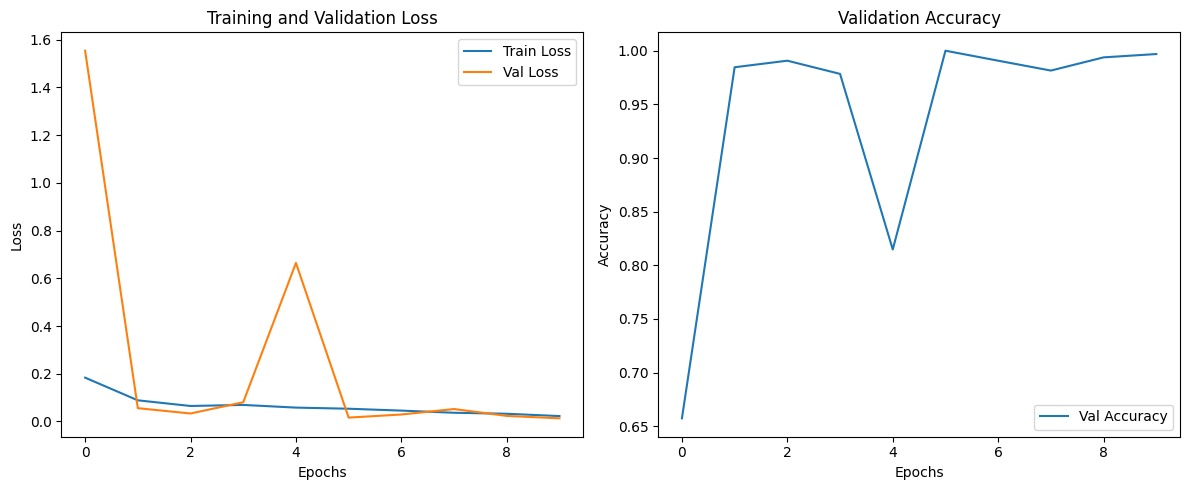

In [26]:
# Add these to your training loop collection
train_losses = [0.1836, 0.0886, 0.0649, 0.0693, 0.0581, 0.0534, 0.0455, 0.0365, 0.0323, 0.0226]
val_losses = [1.5536, 0.0557, 0.0334, 0.0806, 0.6644, 0.0162, 0.0292, 0.0521, 0.0233, 0.0131]
val_accs = [0.6574, 0.9846, 0.9907, 0.9784, 0.8148, 1.0000, 0.9907, 0.9815, 0.9938, 0.9969]

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

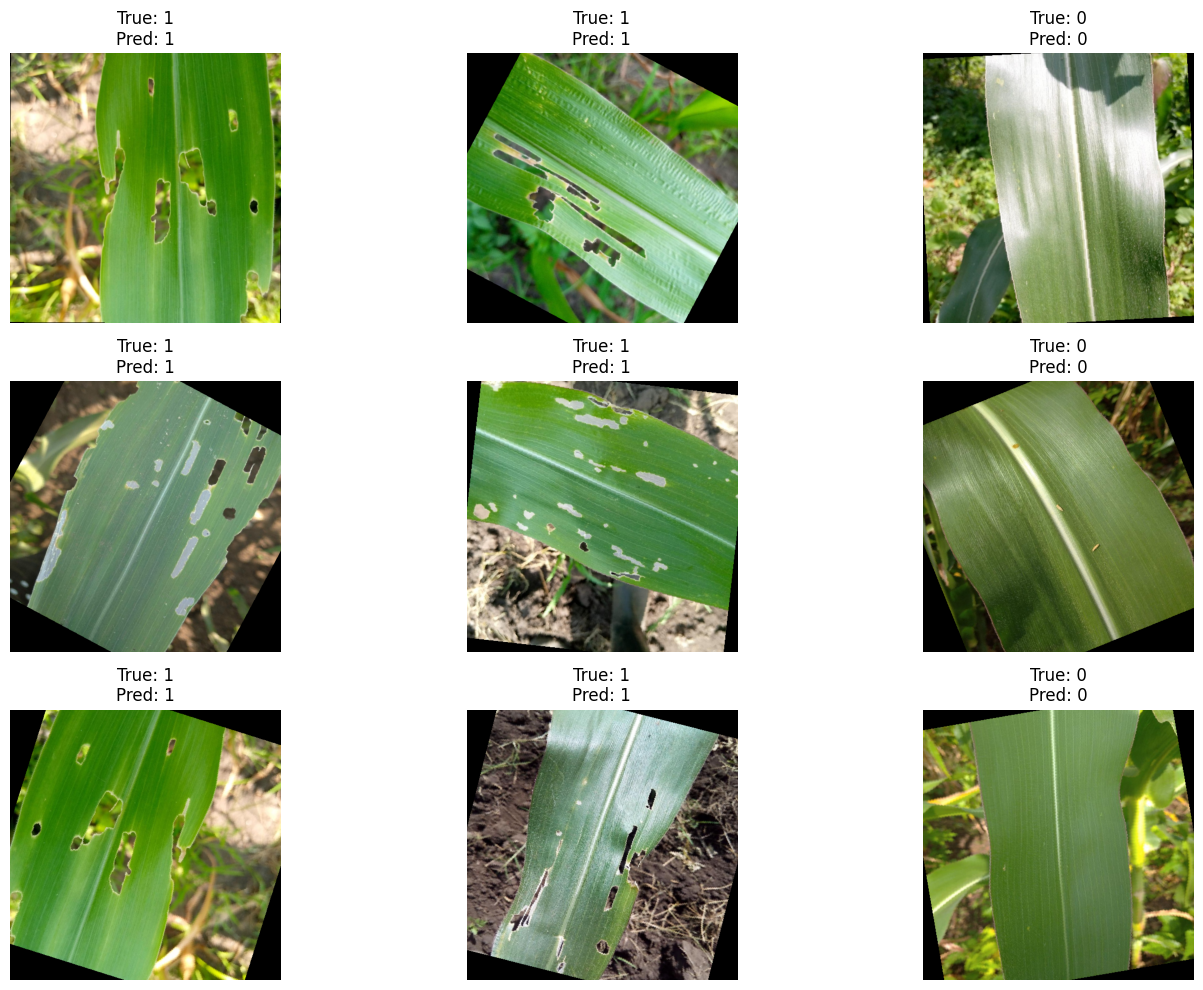

In [27]:
# Inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Get some validation samples
model.eval()
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    idx = np.random.randint(0, len(val_subset))
    image, label = val_subset[idx]
    img = inv_normalize(image).cpu().numpy().transpose((1, 2, 0))
    
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output).item()
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(f"True: {train_dataset.classes[label]}\nPred: {train_dataset.classes[pred]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

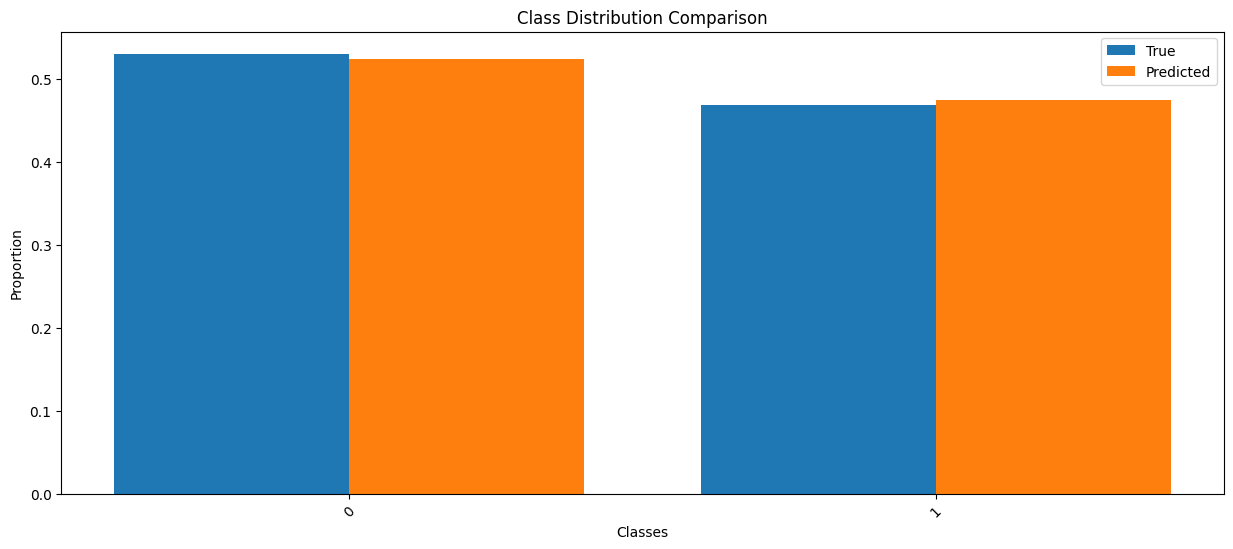

In [28]:
# Get class distributions
unique, counts = np.unique(true_labels, return_counts=True)
true_dist = counts / len(true_labels)

unique, counts = np.unique(pred_labels, return_counts=True)
pred_dist = counts / len(pred_labels)

# Plot distributions
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(true_dist))-0.2, true_dist, 0.4, label='True')
plt.bar(np.arange(len(pred_dist))+0.2, pred_dist, 0.4, label='Predicted')
plt.xticks(np.arange(len(train_dataset.classes)), train_dataset.classes, rotation=45)
plt.title('Class Distribution Comparison')
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.legend()
plt.show()

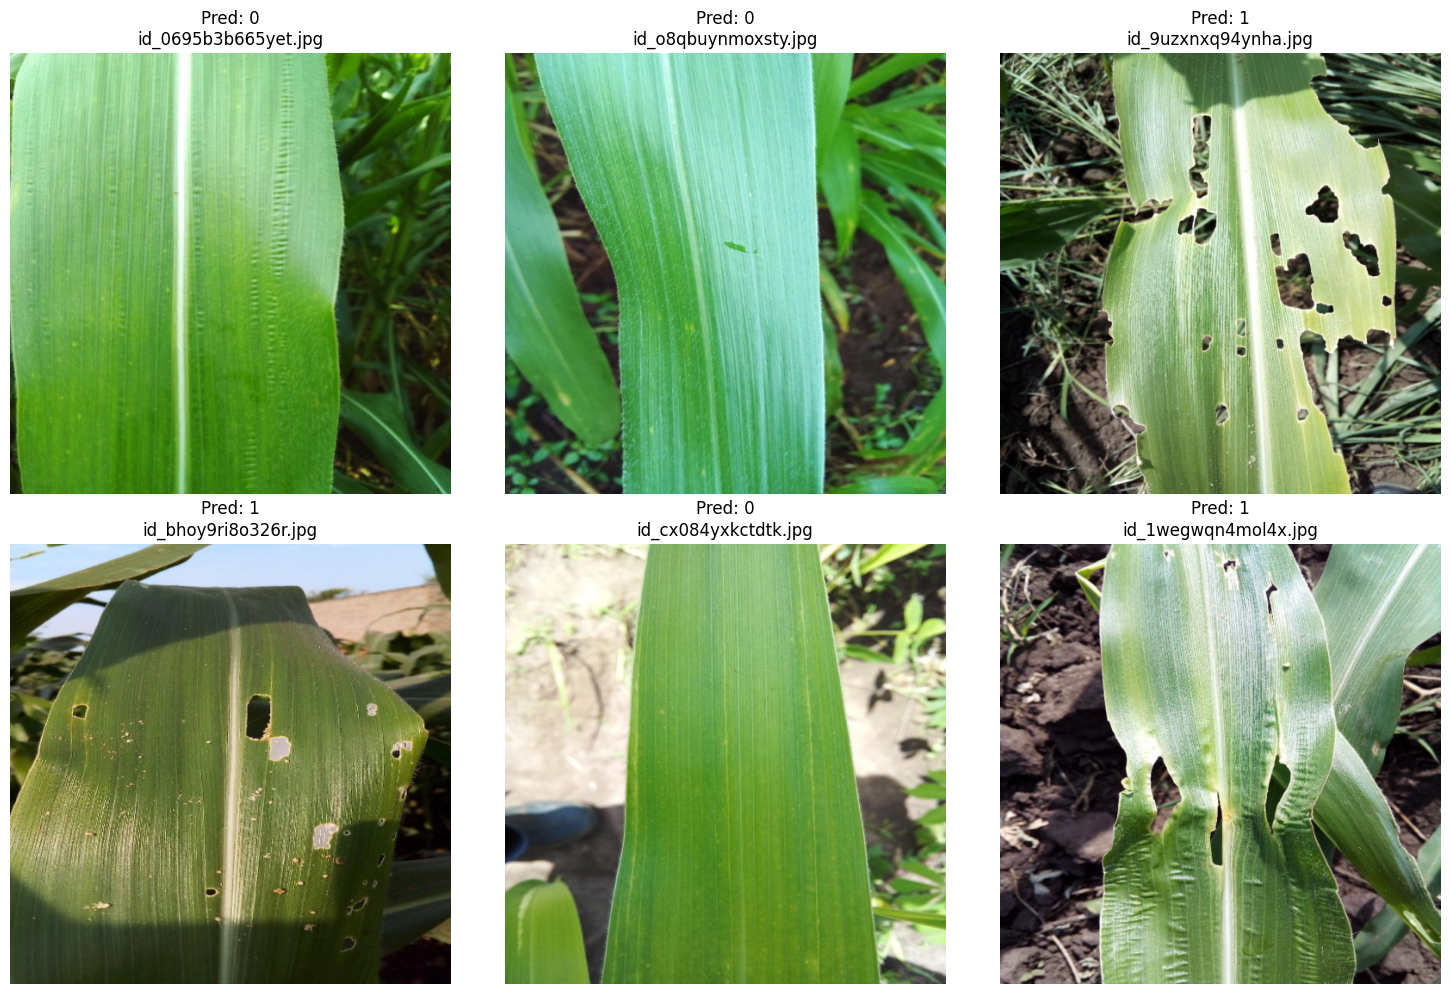

In [29]:
# Visualize test predictions
test_samples = 6
fig = plt.figure(figsize=(15, 10))
for i in range(test_samples):
    idx = np.random.randint(0, len(test_dataset))
    image, filename = test_dataset[idx]
    img = inv_normalize(image).cpu().numpy().transpose((1, 2, 0))
    
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output).item()
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(f"Pred: {train_dataset.classes[pred]}\n{filename}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
best_model_wts = copy.deepcopy(model.state_dict())
torch.save(best_model_wts, 'best_model.pth')